In [1]:
import sys
sys.path.append('..')
import jabble.model
import jabble.loss
import matplotlib.pyplot as plt
from functools import partial
from jax import jit
import jax
import jax.numpy as jnp
from jax.experimental import sparse
import math

import numpy as np

/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:172: SyntaxWarning: Jitted function has static_argnums=(3, 4), but only accepts 4 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


In [2]:
def _sparse_design_matrix(x,xp,basis,a):
    
    '''
        Internal Function for general_interp_simple
        to do:
        make sparse using 'a' and fast
        choose fast sparse encoding
        the fastest for lstsq solve
        time all
    '''
    dx     = xp[1] - xp[0]
    inputs = ((x - xp[0]) / dx) % 1
    index  = (x - xp[0]) // dx
    arange = jnp.arange(-a,a,step=1.0)
    ainds  = jnp.floor(arange)
    
    ms = (index[:,None] + ainds[None,:]).flatten().astype(int)
    # good
    js = (np.arange(0,len(x),dtype=int)[:,None] * np.ones(ainds[None,:].shape)).flatten().astype(int)
    x_tilde = (inputs[:,None] + arange[None,:]).flatten()
    
    data    = basis(x_tilde)
    indices = jnp.concatenate((ms[:,None],js[:,None]),axis=1)
    
    out  = sparse.BCOO((data,indices),shape=(xp.shape[0],x.shape[0]))
    return out

# @partial(jit,static_argnums=[3,4])
def general_interp_sparse(x, xp, ap, basis, a):
    '''XP must be equally spaced
        deal boundary conditions 0D, 0N
        padding points
        with user inputs values

        for future test for a, where basis function goes to zero
    '''
#     a = int((p+1)//2)
    # GET EXACT SPACING from XP
#     assert jnp.allclose(xp[1:] - xp[:-1],dx) # require uniform spacing
#     X    = _sparse_design_matrix(xp,xp,dx,basis,a)

    # This is a toeplitz matrix solve, may be faster also sparse
    # make sparse scipy jax function maybe
#     alphas,res,rank,s = jnp.linalg.lstsq(X,fp)


    # This is to ensure the multiplication with the sparse mat works
    ap = jnp.array(ap)
    design = _sparse_design_matrix(x,xp,basis,a)

    check = (ap[:,None] * design).sum(axis=0)
    print(np.array(design.todense()))
    if isinstance(check, jax.experimental.sparse.bcoo.BCOO):
        return check.todense()

    return check

In [14]:
def _irwin_recursion(j,k,n):
    if k == 0:
        if j < n-1:
            return 0.0
        else:
            return 1.0
    
    return _irwin_recursion(j,k-1,n) + ((-1)**(n+k-j-1) * math.comb(n,k) * math.comb(n-1,j) * k**(n-j-1))

class IrwinHall:
    def __init__(self,n):
        self.n = n
        self.alphas = np.zeros((n+1,n+1))
        for j in range(n+1):
            for k in range(n+1):
                self.alphas[j,k] = _irwin_recursion(j,k,n+1)
        self.alphas = jnp.array(self.alphas)
        
    def __call__(self,x,*args):
        ks = jnp.floor(x + ((self.n+1)/2)).astype(int)
        cond1 = ks >= 0
        cond2 = ks <= (self.n)
        
        f       = jnp.where((cond1*cond2),jnp.polyval(self.alphas[::-1,ks],x + ((self.n+1)/2)),\
                           0.0)
                
        return f

In [15]:
def _full_design_matrix(x,xp,dx,basis):
    from jax.experimental import sparse
    '''
        Internal Function for general_interp_simple
        to do:
        make sparse using 'a' and fast
        choose fast sparse encoding
        the fastest for lstsq solve
        time all
    '''
    dx = xp[1] - xp[0]
    input = (x[None,:] - xp[:,None])/dx
    # cond1 = jnp.floor(input) < -a
    # cond2 = jnp.floor(input) >  a
    # input[(cond1 + cond2).astype(bool)] = 0.0
    # spinput = sparse.BCOO.fromdense(input)

    return basis(input)

# @partial(jit,static_argnums=[3,4])
def general_interp_full(x, xp, ap, basis):
    '''XP must be equally spaced
        deal boundary conditions 0D, 0N
        padding points
        with user inputs values

        for future test for a, where basis function goes to zero
    '''
    dx = xp[1] - xp[0]
    # a = int((p+1)//2)
    # GET EXACT SPACING from XP
#     assert jnp.allclose(xp[1:] - xp[:-1],dx) # require uniform spacing
#     X    = _sparse_design_matrix(xp,xp,dx,basis,a)

    # This is a toeplitz matrix solve, may be faster also sparse
    # make sparse scipy jax function maybe
#     alphas,res,rank,s = jnp.linalg.lstsq(X,fp)
    design = _full_design_matrix(x,xp,dx,basis)
    print(np.array(design))
    return (ap[:,None] * design).sum(axis=0)

In [16]:
class IrwinHallModel(jabble.model.Model):
    def __init__(self,xs,p_val=2,p=None):
        super(IrwinHallModel,self).__init__()
        # when defining ones own model, need to include inputs as xs, outputs as ys
        # and __call__ function that gets ya ther, and params (1d ndarray MUST BE BY SCIPY) to be fit
        # also assumes epoches of data that is shifted between
        self.spline = IrwinHall(p_val)
        self.p_val = p_val
        self.xs = xs
        if p is not None:
            if p.shape == self.xs.shape:
                self.p = p
            else:
                logging.error('p {} must be the same shape as x_grid {}'.format(p.shape,xs.shape))
        else:
            self.p = np.zeros(xs.shape)

    def call(self,p,x,*args):
        a = (self.p_val+1)/2
        
        y = general_interp_sparse(x, self.xs, p, self.spline,a)
        return y
    
class IrwinHallModel_full(jabble.model.Model):
    def __init__(self,xs,p_val=2,p=None):
        super(IrwinHallModel_full,self).__init__()
        # when defining ones own model, need to include inputs as xs, outputs as ys
        # and __call__ function that gets ya ther, and params (1d ndarray MUST BE BY SCIPY) to be fit
        # also assumes epoches of data that is shifted between
        self.spline = IrwinHall(p_val)
        self.p_val = p_val
        self.xs = xs
        if p is not None:
            if p.shape == self.xs.shape:
                self.p = p
            else:
                logging.error('p {} must be the same shape as x_grid {}'.format(p.shape,xs.shape))
        else:
            self.p = np.zeros(xs.shape)

    def call(self,p,x,*args):
        a = (self.p_val+1)/2
        
        y = general_interp_loose(x, self.xs, p, self.spline)
        return y

In [17]:
ys = np.sin(np.linspace(0,3))
xs = np.linspace(0,5)

In [18]:
model_grid = np.linspace(0,5,10)
p_val = 1
model  = IrwinHallModel(model_grid,p_val)
model2 = IrwinHallModel_full(model_grid,p_val)
model3 = jabble.model.BSplineModel(model_grid,p_val)

In [19]:
# obj = jabble.loss.L2Loss()
# data = jabble.dataset.Dataset(xs[None,:],ys[None,:],mask=np.zeros(xs.shape,dtype=bool)[None,:],yerr=np.ones(ys.shape)[None,:])

In [20]:
# model.fit()
# model.new_lbfgsb(obj,data)
# model2.fit()
# model2.new_lbfgsb(obj,data)
# model3.fit()
# model3.new_lbfgsb(obj,data)

In [21]:
model.fix()
model2.fix()
model3.fix()
x_grid = np.linspace(0,5,100)
y_grid = model([],x_grid)
y2grid = model2([],x_grid)
y3grid = model3([],x_grid)

[[1.         0.9090909  0.81818175 0.72727275 0.6363636  0.5454545
  0.4545455  0.36363637 0.27272725 0.18181825 0.090909   0.
  0.09090912 0.18181819 0.27272725 0.36363637 0.4545455  0.54545456
  0.6363636  0.72727275 0.8181818  0.90909094 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0

NameError: name 'general_interp_loose' is not defined

In [22]:
model.fit()
y_grid = model(model.get_parameters(),x_grid)

[[1.         0.9090909  0.81818175 0.72727275 0.6363636  0.5454545
  0.4545455  0.36363637 0.27272725 0.18181825 0.090909   0.
  0.09090912 0.18181819 0.27272725 0.36363637 0.4545455  0.54545456
  0.6363636  0.72727275 0.8181818  0.90909094 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0

In [23]:
# plt.plot(x_grid,y_grid,label='sparse')
# plt.plot(x_grid,y2grid,label='full')
# plt.plot(x_grid,y3grid,label='unknown')

# plt.legend()
# plt.plot(xs,ys,'.r')
# plt.savefig('../out/irwinhallsparsevfull.png')
# plt.show()

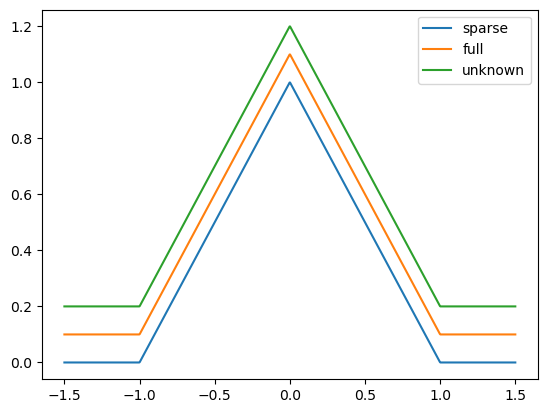

In [24]:
xkernel = np.linspace(-p_val/2-1, p_val/2+1,1000)
plt.plot(xkernel,model.spline(xkernel)+0.0,label='sparse')
plt.plot(xkernel,model2.spline(xkernel)+0.1,label='full')
plt.plot(xkernel,model3.spline(xkernel)+0.2,label='unknown')
plt.legend()
plt.show()

In [14]:
a = (np.arange(3)[:,None] * np.ones(3)[None,:]).flatten()

In [15]:
p_val = 2
xp = np.linspace(0,5,8)
yp = np.array([0,0,0,1,2,0,0,0])
# test_model = IrwinHallModel(xp,p_val,p=yp)
# test_model2 =IrwinHallModel_full(xp,p_val,p=yp)

In [16]:
xs = np.linspace(-2,2,5)
# ys = test_model([],xs)

In [17]:
# y2 = test_model2([],xs)

In [18]:
p_val = 1
basis = IrwinHall(p_val)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [19]:
a  = (p_val+1)/2
ys = general_interp_full(xs,xp,yp,basis)
y2 = general_interp_sparse(xs,xp,yp,basis,a)

[[0.         0.         1.         0.         0.        ]
 [0.         0.         0.         0.6        0.        ]
 [0.         0.         0.         0.4        0.20000005]
 [0.         0.         0.         0.         0.8       ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.         0.         1.         0.39999998 0.        ]
 [0.         0.         0.         0.6        0.8       ]
 [0.         0.         0.         0.         0.20000005]
 [0.         0.         0.         0.         0.        ]
 [0.19999999 0.         0.         0.         0.        ]
 [0.79999995 0.6        0.         0.         0.        ]
 [0.         0.39999998 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


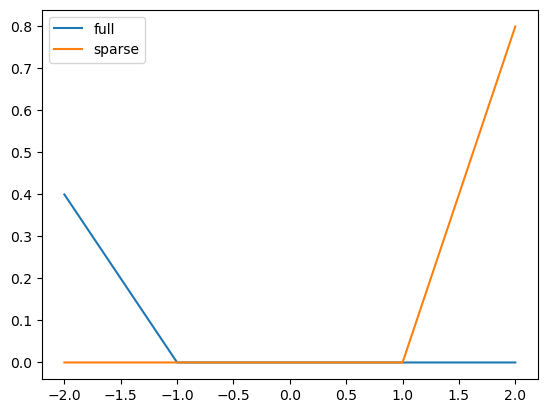

In [20]:
plt.plot(xs,y2,label='full')
plt.plot(xs,ys,label='sparse')
plt.legend()
plt.show()